This notebook generates a series of LTL formula and associated traces from the resultant automaton DAG.

In [1]:
import random
import sys 
import re
import dataclasses
import copy 

import spot
import spot.gen as sg

import ply.lex as lex
import ply.yacc as yacc

from pathlib import Path

from graphviz import Digraph
from graphviz import Graph
from graphviz import Source   # Used to read existing dot files

spot.setup()

In [2]:
class bcolors:
    MAGENTA = '\033[95m'
    BLUE    = '\033[94m'
    CYAN    = '\033[96m'
    GREEN   = '\033[92m'
    ORANGE  = '\033[93m'
    RED     = '\033[91m'
    GREY    = '\033[90m'
    ENDC    = '\033[0m'
    BOLD    = '\033[1m'
    UNDERLINE = '\033[4m'

In [3]:

dLineSeparator = f'='*40
lineSeparator = f'-'*40


----

### The Lexer

In [4]:
class DotLexer(object):
    reserved = {
                'digraph'     : 'DIGRAPH',
                'node'        : 'NODESTYLE',
                'edge'        : 'EDGESTYLE',
                'labelloc'    : 'LABELLOC',
                'rankdir'     : 'RANKDIR',
                'fontname'    : 'FONTNAME',
                'size'        : 'SIZE',
                'width'       : 'WIDTH',
                'height'      : 'HEIGHT',
                'label'       : 'LABEL',
                'shape'       : 'SHAPE',
                'style'       : 'STYLE',
                'fillcolor'   : 'FILLCOLOR',
                'arrowhead'   : 'ARROWHEAD',
                'arrowsize'   : 'ARROWSIZE',
                'peripheries' : 'PERIPHERIES',
                'I'           : 'INITIALSTATE',
               }
    
    literals = ['(',')','<','>','[',']','=',',','{','}']
        
    tokens = [ 
                'STRING',
                'HTMLSTRING',
                'ID',
                'CONNECTOR',
                'NUMBER',
                'NOT',
                'AND',
                'OR',
              ]  + list(reserved.values())
    
    t_NOT       = r'!'
    t_AND       = r'&amp;'
    t_OR        = r'\|'
    t_CONNECTOR = r'->'
    t_NUMBER    = r'(\.|[0-9])[0-9]*'
    
    #A string containing ignored characters (spaces and tabs)
    t_ignore  = ' \t\n\r'
    
    def __init__(self):
        # Build the lexer
        self.lexer = lex.lex(module=self,debug=0,reflags=re.UNICODE | re.VERBOSE)
    
    # def t_INF(t):
    #     r'(<(inf|Inf).*>)|(<\[Büchi\]>)|(<font.*font>)'
    #     t.value = t.value
    #     return t
        
    def t_HTMLSTRING(self,t):
        r'(<([a-zA-Z][a-zA-Z0-9]*)\b[^>]*>.*?</\3>)|<br/>|(<(inf|Inf).*>)|(<\[Büchi\]>)|(<font.*font>)'
    #    r'<([a-zA-Z][a-zA-Z0-9]*)\b[^>]*>.*?</\2>'
        t.value = t.value
        return t
        
    def t_ID(self,t):
        r'[a-zA-Z\u0080-\u3000/][a-zA-Z0-9\.\u0080-\u3000/]*'
        t.type = self.reserved.get(t.value,'ID')    # Check for reserved words
        return t
        
    def t_STRING(self,t):
        r'".*"'
        t.value = t.value
        return t
        
    # # Error handling rule
    def t_error(self,t):
        print("Illegal character '%s'" % t.value[0])
        print(t.value[0].encode('raw_unicode_escape'))
        t.lexer.skip(1)


----

### The Parser

In [5]:
class DotParser(object):

    tokens = DotLexer.tokens
    literals = DotLexer.literals
    reserved= DotLexer.reserved
    
    precedence = (
        ('left', 'AND', 'OR'),
        ('left', 'NOT'),
    )

    def __init__(self):
        self.lexer = DotLexer()
        self.parser = yacc.yacc(module=self,write_tables=False)

    def parse(self,formula,auto):
        self.auto = auto
        self.parser.parse(formula.formulaDot, debug=False)
        return self.auto
        
    def p_graph(self,p):
        'graph : DIGRAPH STRING body'
        p[0] = f'{p[1]} {p[2]} {p[3]}'
    #    print(f'graph:       {p[0]}')
    
    def p_body(self,p):
        '''body : '{' statements '}' '''
        p[0] = f'{p[1]} \n{p[2]} \n{p[3]}'
    #    print(f'Body:        {p[0]}')
    
    def p_statements2(self,p):
        '''statements : statements  statement
                      | statements  style
                      '''
        p[0] = f'{p[1]} {p[2]}\n'
    #    print(f'statements2: {p[0]}')
    
    def p_statements1(self,p):
        '''statements : statement'''
        p[0] = f'{p[1]}'
    #    print(f'statements1: {p[0]}')
    
    def p_rankdir(self,p):
        '''statement : RANKDIR '=' ID'''
        p[0] = f'{p[1]} = {p[3]}'
    #    print(f'rankdir:     {p[0]}')
    
    def p_label(self,p):
        '''label : LABEL '=' html
                 | LABEL '=' STRING 
                 | LABEL '=' extra
                 '''
        p[0] = Label(p[1],p[3])
    #    print(f'label:       {p[0]}, {bcolors.RED}{type(p[0].value)}{bcolors.ENDC}')
    #    print(f'label.value: {p[0].label}: {p[0].value}')
    
    def p_extraText(self,p):
        '''extra : HTMLSTRING
                 | extra HTMLSTRING
                 '''
        if len(p) == 2:
            p[0] = f'{p[1]}'
        else:
            p[0] = f'{p[1]} {p[2]}'
            
    def p_nodeStyle(self,p):
        '''statement : NODESTYLE '[' style ']' '''
        p[0] = f'{p[1]} {p[2]} {p[3]} {p[4]}'
    #    print(f'node style:  {p[0]}')
    
    def p_edgeStyle(self,p):
        '''statement : EDGESTYLE '[' style ']' '''
        p[0] = f'{p[1]} {p[2]} {p[3]} {p[4]}'
    #    print(f'edge style:  {p[0]}')
    
    def p_node(self,p):
        '''statement : NUMBER '[' style ']' 
                     | INITIALSTATE '[' style ']' '''
    #    p[0] = f'{p[1]} {p[2]} {p[3]} {p[4]}'
        self.auto.addState(p[1],p[3])
    #    print(f'node:  {p[1]} | {p[3]}')
    
    def p_nodeConnect(self,p):
        '''statement : INITIALSTATE CONNECTOR NUMBER 
                     | INITIALSTATE CONNECTOR NUMBER '[' style ']'
                     | NUMBER CONNECTOR NUMBER 
                     | NUMBER CONNECTOR NUMBER '[' style ']' 
                     '''
        if len(p) == 4:
            p[0] = f'{p[1]} {p[2]} {p[3]}'
            self.auto.addEdge(p[1],p[3],Label('label',Predicate('1')))
        else:
            p[0] = f'{p[1]} {p[2]} {p[3]} {p[4]} {p[5]} {p[6]}'
            self.auto.addEdge(p[1],p[3],p[5])
    #        print(f'{p[5]}, {bcolors.RED}{type((p[5].label))}, {type((p[5].value))}{bcolors.ENDC}')
    #        print(f'{p[5].value.predicates()} |{(p[5].label)}|')
            self.auto.addPredicate(p[5].value.predicates())
    #    print(f'nodeConnect:  {p[0]}')
    
    def p_style(self,p):
        '''style : style ','
                 | style LABELLOC    '=' STRING 
                 | style SHAPE       '=' STRING
                 | style STYLE       '=' STRING
                 | style STYLE       '=' ID
                 | style FILLCOLOR   '=' STRING
                 | style FONTNAME    '=' STRING
                 | style ARROWHEAD   '=' ID
                 | style ARROWSIZE   '=' NUMBER
                 | style WIDTH       '=' NUMBER
                 | style WIDTH       '=' STRING
                 | style HEIGHT      '=' NUMBER
                 | style HEIGHT      '=' STRING
                 | style PERIPHERIES '=' NUMBER
                 | LABELLOC    '=' STRING 
                 | SHAPE       '=' STRING
                 | STYLE       '=' STRING
                 | STYLE       '=' ID
                 | FILLCOLOR   '=' STRING
                 | FONTNAME    '=' STRING
                 | ARROWHEAD   '=' ID
                 | ARROWSIZE   '=' NUMBER
                 | WIDTH       '=' NUMBER
                 | WIDTH       '=' STRING
                 | HEIGHT      '=' NUMBER
                 | HEIGHT      '=' STRING
                 | PERIPHERIES '=' NUMBER
                 '''
        if len(p) == 2:
            p[0] = f'{p[1]}'        
        elif len(p) == 3:
            p[0] = f'{p[1]} {p[2]}'        
        elif len(p) == 4:
            p[0] = f'{p[1]} = {p[3]}'
        else:
            p[0] = f'{p[1]} {p[2]} = {p[4]}'
    #    print(f'style:       {p[0]}, {bcolors.BLUE}{type(p[0])}{bcolors.ENDC}')
    
    def p_styleLabel(self,p):
        '''style : label
                 | style label
                 '''
        if len(p) == 2:
            p[0] = p[1]
        elif len(p) == 3:
            p[0] = p[1].addLable(p[2])
    #    print(f'styleLabel:  {p[0]}, {bcolors.RED}{type(p[0])}{bcolors.ENDC}')
       
    def p_html(self,p):
        '''html : '<' htmlbody '>'
                '''
        p[0] = p[2]
    #    p[0] = f'{p[1]} {p[2]} {p[3]}'
    #    print(f'html:         {p[0]}, {bcolors.RED}{type(p[0])}{bcolors.ENDC}')
    
    def p_htmlbody(self,p):
        '''htmlbody : STRING
                    | equation
                    | htmlbody equation  
                    | htmlbody '(' HTMLSTRING ')'
                    '''
        if len(p) == 2:
            p[0] = p[1]
        elif len(p) == 3:
            p[0] = p[1].addLable(p[2])
        else:
            p[0] = p[1].addLable(p[3])
            
    #    print(f'htmlbody:     {p[0]}, {bcolors.RED}{type(p[0])}{bcolors.ENDC}')
    
    def p_equation_html(self,p):
        ''' equation : equation HTMLSTRING
                     | equation '[' ID ']'
                     | equation '(' HTMLSTRING ')'
                     '''
    
        if len(p) == 3:
            p[0] = p[1].addLabel(p[2])
        else:
            p[0] = p[1].addLabel(p[3])
    #    print(f'html equation:    {p[0]}')
    
    def p_equation_binary_and(self,p):
        ''' equation : equation AND equation
                     '''
        p[0] = AndNode(p[1],p[3])
    #    print(f'EQ And:   {p[0]} {type(p[0])}')
    
    def p_equation_binary_or(self,p):
        ''' equation : equation OR equation
                     '''
        p[0] = OrNode(p[1],p[3])
    #    print(f'EQ Or:    {p[0]} {type(p[0])}')
    
    def p_equation_term(self,p):
        ''' equation : term
                     '''
        p[0] = p[1]
    #    print(f'EQ term:  {p[0]} {type(p[0])}')
        
    def p_equation_unary(self,p):
        ''' equation : NOT equation
                     '''
        p[0] = UniNode(p[1],p[2])
    #    print(f'EQ Uni:   {p[0]} {type(p[0])}')
    
    def p_equation_sub(self,p): 
        ''' term : '(' equation ')'
        '''
        p[0] = p[2]
    #    print(f'EQ Sub:  {p[0]} {type(p[0])}')
        
    def p_equation_predicate(self,p):
        ''' term : NUMBER
                 | ID
                 '''
        p[0] = Predicate(p[1])
    #    print(f'EQ Pred: {p[0]} {type(p[0])}')
        
    def p_graphsize(self,p):
        '''statement : SIZE '=' STRING '''
        p[0] = f'{p[1]} = {p[3]}'
    #    print(f'graphsize:   {p[0]}')
    
    # Error rule for syntax errors
    def p_error(self,p):
        print("Syntax error in input!")
        print(f'{p}')


In [22]:
__file__ = "DC_Parser.ipynb"

# Build the lexer
#lexer = lex.lex(debug=0,reflags=re.UNICODE | re.VERBOSE)

----
#### Code for testing just the parser

In [23]:
# Give the lexer some input
#lexer.input(graph)

# Tokenize
#for tok in lexer:
#    print(f'{tok.type:15} {tok.value:<6} {tok.lineno:3} {tok.lexpos:3} {tok}')

----
### LTL Tracegen

What follows is all the support code for building an automaton from an equation. The basic flow of the code is as follows:

* Provide an equation. It may be given directly or randomly generated by Spot.
* Spot is used to convert the equation into a Buchi automaton in dot format.
* The dot graph is parsed into an new automaton.
* Randomly walk the automaton and capture the predicate states on the edges taken.

In [24]:
def getSeed(rndSeed=False,printSeed=False):
#    seed = 96996 # generates a long diagram with multiple buchi labels
    seed = 79398 # generates a medium diagram with a graph label containing an & - not accounted for in yacc syntax
#    seed = 64165 # generates a graph title with brackets and html
    
    if rndSeed == True:
        seed = random.randrange(100000)

    if printSeed == True:
        print(f'Seed Used: {seed}')

    return(seed)

In [25]:
class DotGraph:
    def __init__(self):
        self.dot = Digraph(comment='Digraph generated by LTL_TraceGen_Spot',graph_attr=dict(rankdir='LR'))
        self.dot.attr('node',shape='circle',fontname="Helvetica")
        self.dot.attr('edge',fontname='Helvetica')


    def addState(self,state,color='black',fontcolor='black'):
        self.dot.node(state,color=color,fontcolor=fontcolor)

    def addEdge(self,fromState,toState,label="",color='black',fontcolor='black'):
        self.dot.edge(fromState,toState,label,color=color,fontcolor=fontcolor)

    def addTitle(self,title):
        pass
        
    def showGraph(self,graphPrint,graphSource,graphFile):
    
        if graphSource == True:
            print(self.dot)
    
        if graphPrint == True:
            display(self.dot)
    
        if graphFile['save'] == True:
            self.dot.render(graphFile['name'], format=graphFile['format'])
        

----
#### Node Classes

The following classes are to create an binary tree of an equation


In [264]:
class Node:

    def addLabel(self,label):
        return self

    def trace(self):
        pass

    def evaluate(self):
        pass

    def clearState(self):
        pass

class BinNode(Node):
    def __init__(self,op,childL=None, childR=None):
        self.op = op
        self.childL = childL
        self.childR = childR
        self.stateL : (Bool, None) = None
        self.stateR : (Bool, None) = None

    def predicates(self):
        return list(set(self.childL.predicates() + self.childR.predicates()))

    def clearState(self):
        self.stateL = None
        self.stateR = None

        self.childL.clearState()
        self.childR.clearState()

    def __repr__(self):
        return f'({self.childL} {self.op} {self.childR})'

class AndNode(BinNode):
    def __init__(self,childL=None, childR=None):
        super().__init__('&',childL,childR)

    def trace(self):
        return self.childL.trace() + self.childR.trace()

    def evaluate(self,step):
        if self.stateL == None:
            self.stateL = self.childL.evaluate(step)

        if self.stateR == None:
            self.stateR = self.childR.evaluate(step)

        if (self.stateL != None) and (self.stateR != None):
            state = self.stateL & self.stateR
        else:
            state = None
            
#        print(f'AND {step} {self.stateL} & {self.stateR} {state}')
        return state
        
class OrNode(BinNode):
    def __init__(self,childL=None, childR=None):
        super().__init__('|',childL,childR)

    def trace(self):
        if random.randint(0,1) == 0:
            return (self.childL.trace())
        else:
            return (self.childR.trace())

    def evaluate(self,step):
        if self.stateL == None:
            self.stateL = self.childL.evaluate(step)

        if self.stateR == None:
            self.stateR = self.childR.evaluate(step)

        if (self.stateL != None) and (self.stateR != None):
            state = self.stateL | self.stateR
            
        elif (self.stateR != None):
            state = self.stateR
            
        elif (self.stateL != None):
            state = self.stateL
            
        else:
            state = None
            
#        print(f'OR  {step} {self.stateL} | {self.stateR} {state}')
        return state

class UniNode(Node):
    def __init__(self,op,child=None):
        self.op = op
        self.child = child
        self.state : (Bool, None) = None

    def predicates(self):
        return self.child.predicates()

    def trace(self):
        children = []
        for child in self.child.trace():
            if child[0] == '!':
                children.append(child[1:])
            else:
                children.append(f'!{child}')
        return children

    def evaluate(self,step):
        if self.state == None:
            self.state = self.child.evaluate(step)
            if self.state != None:
                self.state = not(self.state)
#            print(f'NOT {step} {self.state}')
        return self.state

    def clearState(self):
        self.state = None
        self.child.clearState()
        
    def __repr__(self):
        return f'{self.op}{self.child}'

class Predicate(Node):
    def __init__(self,value):
        self.value = value
        self.state = None

    def predicates(self):
        return [self.value]

    def trace(self):
        return [self.value]

    def evaluate(self,step):
        if self.state == None:
            if (self.value in step) or (self.value == '1'):
                if step[0] == '!':
                    self.state = False
                else:
                    self.state = True
        #     print(f'PRD {step} {self.value} {self.state}')
        # else:
        #     print(f'PRD {step} {self.value} X')
        return self.state

    def clearState(self):
        self.state = None

    def __repr__(self):
        return f'{self.value}'
        

----
The following classes are used to create an automaton data structure of labeled Nodes and Edges  

The data structures go together as follows:

<img src="LTL TraceGenDataStruct.svg" width=”5000” align="center" /> 




In [265]:
@dataclasses.dataclass
class Step:

    fromState  : str = ''
    toState    : str = ''
    predicates : str = ''
        
    def __repr__(self):
        str = f'{self.fromState:3} -> {self.toState:3}: {self.predicates}'

        return str

In [266]:
@dataclasses.dataclass
class Trace:
    steps : list[Step] =  dataclasses.field(default_factory=list)
    position : int = 0

    def addStep(self,step):
        self.steps.append(step)

    def step(self):
        for step in self.steps:
            yield step.predicates

    def start(self):
        self.position = 0

    def next(self):
        if self.position < len(self.steps):
            self.position += 1
            return self.steps[self.position-1]
        else:
            return None

    def back(self):
        if self.position > 0:
            self.position -= 1
            return self.steps[self.position]
        else:
            return None

    def traceAsStr(self):
        str = ''
        for step in self.steps:
            str = str + ','.join(step.predicates) + ';'
        return str

    def __repr__(self):
        str = f'S   -> S\'   Predicates\n{lineSeparator}\n'
        for step in self.steps:
           str = str + f'{step}\n'
        return str
    
    

In [267]:
class Label:

    def __init__(self,label: str,value: Node):
        self.label = label
        self.value = value

    def trace(self):
        return(self.value.trace())

    def evaluate(self,step):
        self.value.clearState()
        finalEval = None
        for symbol in step.predicates:
            eval = self.value.evaluate(symbol)
            if eval != None:
                if finalEval == None:
                    finalEval = eval
                else:
                    finalEval = finalEval & eval

        stepPreds = [step.predicates[i].replace('!','') for i in range(len(step.predicates))]
        totalPredsCovered = len(set(self.value.predicates()).intersection(stepPreds))
#        print(f'{self.value.predicates()} vs {stepPreds} -> {set(self.value.predicates()).intersection(stepPreds) != set(self.value.predicates())} Covered: {totalPredsCovered}')
        if type(self.value) != OrNode:
            if set(self.value.predicates()).intersection(stepPreds) != set(self.value.predicates()):
                finalEval = None
        return [finalEval, totalPredsCovered]
        
    def __repr__(self):
        str = f'{self.value}'

        return str

In [268]:
class Edge:
    
    def __init__(self,fromState,toState,label):
        self.fromState   = fromState
        self.toState     = toState
        self.label       = label
        self.totalVisits = 0

    def reset(self):
        self.totalVisits = 0

    def getNextState(self):
        return self.toState.stateNum
        
    def trace(self):
        return(self.label.trace())

    def evaluate(self,step):
        eval = self.label.evaluate(step)
        if eval == True:
            print(f'State: {self.fromState.stateNum} -> {self.toState.stateNum}, Symbols: {step.predicates} : {eval[0]} {self.label}')
        return [self.toState,eval]
        

    def __repr__(self):

        return  f'\t{self.toState.stateNum}: {self.label}'
    

In [269]:
class State:

    label    = ''
    edgesOut = {}
    
    def __init__(self,stateNum,label):
        self.stateNum     = stateNum
        self.label        = label
        self.edgesOut     = []

        # Vars for tracking steps through state
        self.statesSeen   = {}
        self.visitCount   = 0
        self.stateVisited = False

    def addEdge(self,edge):
        self.edgesOut.append(edge)

    def isTerminal(self):
        
        terminal = True
        if len(self.edgesOut) == 0:
            return terminal
        else:
            for edge in self.edgesOut:
                if edge.getNextState() != self.stateNum:
                    return False
        return terminal

    def checkLowCoverage(self,fromState,visitList,min):
#        print(f'!')
        lowCoverageEdges = []
        for edge in self.edgesOut:
            if edge.toState not in visitList:
#                print(f'edge: {edge} cnt: {edge.totalVisits}')
                if edge.totalVisits <= min:
                    lowCoverageEdges.append(edge)
                else:
                    edgeList = edge.toState.checkLowCoverage(edge.toState,visitList+[fromState],min)
                    if len(edgeList) > 0:
                        lowCoverageEdges.append(edge)
#        print(lowCoverageEdges)
#        print('!!')
        return lowCoverageEdges
        
    def step(self):
#        print('>')
        lowCoverEdges = self.checkLowCoverage(self,[],0)
        if len(lowCoverEdges) == 0:
            lowCoverEdges = self.edgesOut
        edge  = lowCoverEdges[random.randint(0, len(lowCoverEdges)-1)]   
        edge.totalVisits += 1
        self.statesSeen[edge.toState.stateNum] += 1
        self.stateVisited = True
#        print(f'CurState: {self.stateNum}, Next State: {edge.toState.stateNum}, Trace: {trace}, States Seen: {self.statesSeen}, Coverage: {lowCoverEdges}')
#        print('<\n')
        return Step(self.stateNum,edge.toState.stateNum,edge.trace())

    def evaluate(self,trace: Trace, traceLog: list):
        edgeEval = []
        traceLog.append(self.stateNum)
#        print(f'State> {self.stateNum} {traceLog}')
        eval = []
            
        step = trace.next()
        if step != None:
            for edge in self.edgesOut:
                eval = edge.evaluate(step)
                if eval[1][0] == True:
                    edgeEval.append(eval)
    
#            print(edgeEval)
            if len(edgeEval) == 1:
                nextState = edgeEval[0][0]
                maxCover = edgeEval[0][1][1]
            else:
                maxCover = 0
                nextState = None
                for candidate in edgeEval:
    #                print(f'{candidate} | {candidate[0].stateNum} | {candidate[1][1]}')
                    if candidate[1][1] > maxCover:
                        maxCover = candidate[1][1]
                        nextState = candidate[0]

            if nextState == None:
                print(f'No next state @ state: {self.stateNum} Step: {step.predicates}')
            else:
                traceLog, eval = nextState.evaluate(trace,traceLog)
#        print(f'State< {self.stateNum}')
        return traceLog, eval 

    def edgeList(self):
        return self.edgesOut

    def edgesVisited(self):
        edgeVisitCnt = 0
        for edge in self.edgesOut:
            if edge.totalVisits > 0:
                edgeVisitCnt += 1
        return edgeVisitCnt

    def edgesTotal(self):
        return len(self.edgesOut)
        
    def reset(self):
        
        for edge in self.edgesOut:
            edge.reset()
            self.statesSeen[edge.toState.stateNum] = 0
        
        self.visitCount   = 0
        self.stateVisited = False
        
    def __repr__(self):
        str =  f'{self.stateNum} Total Edges Out: {len(self.edgesOut)}\n'
        for edge in self.edgesOut:
            str = str + f'{edge}\n'
        return str
    

In [270]:
class Automaton:

    states      = {}
    predicates  = []
    terminals   = []
    startStates = []
    curState    = 0
    trace       = []
    traceLog    = []
    allTraces   = []
    
    def __init__(self):
        self.states      = {}
        self.edges       = []
        self.predicates  = []
        self.terminals   = []
        self.startStates = []
        self.trace       = []
        self.allTraces   = []

    def addState(self,stateNum,stateLbl):
        if stateNum not in self.states:
            self.states[stateNum] = State(stateNum,stateLbl)
            if stateNum == 'I':
                self.startStates.append(stateNum)
#            print(f'addNode: {stateNum} {stateLbl}')
        else:
            print(f'addNode: {stateNum} Duplicate Node')

    def addEdge(self,stateFrom,stateTo,label):
        edge = Edge(stateFrom,stateTo,label)
        self.edges.append(edge)
        self.states[stateFrom].addEdge(edge)
#        print(f'addEdge {stateFrom} {stateTo} {label}')
        pass

    def addPredicate(self,predicates):
        if '1' in predicates:
            predicates.remove('1')
        self.predicates = list(set(self.predicates + predicates))

    def finishBuild(self):
        for state in self.states.values():
            for edge in state.edgesOut:
                edge.fromState = self.states[edge.fromState]
                edge.toState   = self.states[edge.toState]

        tmpList = []
        for stateNum in self.startStates:
            if (stateNum == 'I'):
                if (len(self.states['I'].edgesOut) == 1):
                    newStart = self.states['I'].edgesOut[0].toState.stateNum
                else:
                    newStart = 'I'
                tmpList.append(newStart)
            else:
                tmpList.append(stateNum)
        self.startStates = tmpList
            
                
    def getTerminals(self):
        self.terminals  = []
        for stateNum, stateStruct in self.states.items():
            if stateStruct.isTerminal() == True:
                self.terminals.append(stateNum)
                
    def reset(self,resetLog=True):

        if resetLog == True:
            for stateNum, stateStruct in self.states.items():
                stateStruct.reset()
            self.allTraces   = []

        self.trace = Trace()
        self.curState = self.startStates[0]

    def step(self):
        step  = self.states[self.curState].step()
        self.states[step.toState].visitCount += 1
        self.trace.addStep(step)
        self.curState = step.toState

    def evaluate(self,trace):
        trace.start()
        self.traceLog = []
        self.traceLog, eval = self.states[self.startStates[0]].evaluate(trace,self.traceLog)

    def genTrace(self,tracePrint=False):
        
        self.reset(resetLog=False)
    
        for i in range(0,runLen):
            self.step()
    
        if tracePrint == True:
            self.printTraceLog()
        self.allTraces.append(self.trace)

    def getTrace(self):
        return self.trace.traceAsStr()
            
    def printTraceLog(self):
        print(f'{self.trace}')
        
    def printVisitLog(self):

        print(f'{dLineSeparator}\nFrom State To State Visit Count')
        stateStrTable  = []
        edgeStrTable = []
        maxLenStr = 0
        for stateNum, stateStruct in self.states.items():
            str = f'{stateNum}: '
            for state, item in stateStruct.statesSeen.items():
                str = str + f'{state:>3} -> {item:3} '
            maxLenStr = max(len(str),maxLenStr)
            stateStrTable.append(str)
            edgeStrTable.append(f'Edges Out: {stateStruct.edgesVisited():3}/{stateStruct.edgesTotal():3}')
        for i in range(len(stateStrTable)):
            pad = maxLenStr - len(stateStrTable[i])
            print(f'{stateStrTable[i]}{" "*pad} | {edgeStrTable[i]}')

    def printGraph(self,graphPrint,graphSource,graphFile):
        self.graph = DotGraph()
        edgeList = []
        for stateNum, stateStruct in self.states.items():
            if stateStruct.stateVisited == True:
                self.graph.addState(stateNum,color='green')
            else:
                self.graph.addState(stateNum,color='black')
            edgeList = edgeList + stateStruct.edgeList()

        for edge in edgeList:
            if edge.totalVisits > 0:
                self.graph.addEdge(edge.fromState.stateNum,edge.toState.stateNum,f'{edge.label}',color='green')
            else:
                self.graph.addEdge(edge.fromState.stateNum,edge.toState.stateNum,f'{edge.label}',color='black')

        self.graph.showGraph(graphPrint,graphSource,graphFile)
        
    def __repr__(self):
        str = ''
        for stateNum, stateStruct in self.states.items():
            str = str + f'{stateNum:>3}: {stateStruct}'

        if len(str) == 0:
            str = 'Empty automaton structure'

        return str

#### Formula Class

This class is the starting point of the process, holding the original formula and methods to print and interact with it.

One can either request a randomly generated formula from Spot, use a predefined one, or provide one as a string.

In [271]:
class Formula:

    def __init__(self,formula,dOptions):
        self.formulaStr = formula
        self.formula = self.formulaStr.translate(dOptions)
        self.formulaDot = self.formula.to_str('dot')
        
    @classmethod
    def getRndFormula(cls,dOptions,totalFormulas=10,rndSeed=True):
    
        seed = getSeed(rndSeed,printSeed=True)

        for formulaStr in spot.randltl(3,totalFormulas,seed=seed, tree_size=(1, 40)):
            pass

        return cls(formulaStr,dOptions)

    @classmethod
    def getFixedFormula(cls,dOptions,fNumber=0):

        formula = [
                  '!(g | y )& r & X(r U( !(r|g) & y & X((y) U ((g & !(y | r)) & X(g U (!(g | y )& r))))))',
                  'G(r->X((r)U(y&X((y)U(g)))))',
                  '(p&X(q | (r & G(s))))U(t&F(u))',
                  '((!s & !p & t & r)  U (!r U ((!u & !t & (!p & X(p|s))))))',
                  'G((((p & !q) U((!p & q) | (r & G(s))))U(t &G(F(u) & X u))) & (t -> !p))',
                  '!(g | y )& r & X(r U( !(r|g) & y & X((y) U ((g & !(y | r)) & X(g U (!(g | y )& r))))))',
                  'G(((p & !q) U(!p & q)) U ((G t ) & X u))',
                  '(G !(c1 & c2)) & (GF c1) & (GF c2)',
                  'GF s &  GF p & GF q & GF !t & GF !u & G(t -> X!p)& G(u -> X!q)& G(p -> !t)& G(q -> !u)',
                  'G(!a | ((!b | X(!c U (d & Fe)) | X(c R !d)) U (c | G(!b | X(!c U (d & Fe)) | X(c R !d)))))',
                  'G((q & X F r) -> X(p -> (!r U s)) U r)',
                  'r & (GF r &  GF y & GF g & G(r -> X(g & !r & !y))& G(g -> X(!g & !r & y))& G(y -> X(!g & r & !y)) & G( g | r | y) )',
                  'r & (GF r &  GF y & GF g & G(r -> r U (g & !r & !y))& G(g -> g U(!g & !r & y))& G(y -> y U(!g & r & !y)) & G( g | r | y) )',
                  'r & ( G(r -> (r U g))& G(g -> (g U y)) & G(y -> (y U r)) & G(( g & !r & !y) | (!g & r & !y) | (!g & !r & y)))',
                  '( (( (p -> F( (u & q))) -> (!p -> !q)) & G( (q -> F(s)))) | G( (!t | !u)))',
                  'F(s)&F(p)&F(q)&(p->!t)&(q->!u)',
                  'G((p ∨ (q ∧ r)) -> X((s) U (t ∧ u)))',
                  'G((p & !t) -> X((q -> X(!q U (r & s & t))) U ((!r | !s) & u)))',
                  'G((p & !t) -> X((q -> X(!q U (r & s & t))) U (((!r & !s) | t | u) U (t & u))))',
                  'G((p & !t) -> X((!q & !u) -> X((q <-> (!r & s & t)) U (!s U ((q & !u) | (!q & (r | !t)))))))',
                  'G(F(p & (q | r)) -> X( X(!s)))',
                  'G((p & (q | r)) -> X(X(s)))',
                  'F(G(p -> X(q))) & G(r -> (F(!s)))',
                  'G(p -> (X(q) & G(r -> F(!s))))',
        ]

        return cls(spot.formula(formula[fNumber]),dOptions)

    @classmethod
    def setFormula(cls,dOptions,formula=''):

        return cls(spot.formula(formula),dOptions)

    def getStartState(self):
        return self.formula.get_init_state_number()
        
    def showGraph(self,graphPrint,graphSource,graphFile):
        dot = Source(self.formulaDot)
    
        if graphPrint == True:
            display(dot)
    
        if graphFile['save'] == True:
            dot.render(graphFile['name'], format=graphFile['format'])
    
        if graphSource == True:
            print(self.formulaDot)

    def printSelf(self):

        print(f'Starting formula:\n{self.formulaStr}')
        display(self.formulaStr)
        
        


This is a little debug code that allows me to limit the length of the input to the parser so there's less text to churn through after throwing an error. It also helps to isolate the erroneous line.

In [272]:

# p = re.compile('digraph(.*)\n(.*)\n(.*)\n(.*)\n(.*)\n(.*)\n(.*)\n(.*)\n(.*)\n(.*)\n(.*)\n(.*)')
# g = p.match(graph).group() + '\n}'

# g = graph
# print(g)

----
# Start of the actual program.

To control the execution of this generator, there are the option parameters to set:

#### Specification Related Parameters
`formulaType` This defines where the specification comes from. The options are:
* 'Fixed' Used a fixed formula found in the Formula class.
* 'Random' Ask Spot for a random formula
* 'Given' Give the formula directly
  
`fixedFormulaNum ` If using a fixed formula, this parameter specifies which one. Currently allows selection 0-15  
`rndNumFormulas` If Spot is generating the formula, define how many to generate. The code will attempt to select an interesting one  
`startFormula` The specific formula to use  

`dOptions` All the formulas are sent to Spot to generate an automaton. This paramenter defines what type of automaton to create. The options are `Complete`, `Unambiguous`, `tgba`. See the Spot documentation for more info.

`rndSeed=True` For repeatability, set this to false. when set to True, the seed used is defined in getSeed().  

#### Trace Related Parameters
`runLen` Length of each trace genrated  
`numRuns` Number of traces to generate  

#### Graph Display Control
`path` Defines where saved files will go  

`graphPrint` Print the original automaton graph  
`graphSource`Save the graph source in dot format  
`graphFile` A dictionary of graph file output control  

`tracePrint` Display a detail log of each trace showing predicates along with stating and ending states for each trace step  
`traceGraphPrint` Display the automaton graph color coded for coverate. Green = path or state seen in at least one trace  
`traceSource` Save the graph source in dot format 
`traceGraphFile` A dictionary of graph file output control  


In [853]:
formulaType = 'Given' #'Fixed', 'Random', 'Given'
startFormula = 'G(r->X((r)U(y&X((y)U(g)))))'
startFormula = '(l ↔ p) ∧ F(¬p)'
startFormula = '(l ↔ p) ∧ F(¬p) & G !((l & !p) | (!l & p))'
startFormula = 'G(l ↔ p) ∧ F(¬p)'
startFormula = 'G((t ↔ y) ∧ (t → p))'
startFormula = '(G((l ↔ p) ∧ F(¬p)) ∧ G((t ↔ y) ∧ (t → p)))'
#startFormula = 'G(((l ↔ p) ∧ ((t ↔ y) ∧ (t → p)) ∧ F(¬p)))'
startFormula = '(G((l ↔ p) ∧ F(¬p)) ∧ G((t → (y ∧ X¬y)) ∧ (t → X(b U b)) ∧ (¬(b ∧ t) → X¬b) ∧ (t → p)))'
startFormula = 'G(l <-> p) & G(t -> (p & y & X (!t & !y))) & F(!p)'
#startFormula = 'G(l <-> p) & G((!y U (p & t & X!y))) & F(!p)'
#startFormula = 'GF r &  GF y & GF g & G(r -> X(g & !r & !y)) & G(g -> X(y & !r & !g))& G(y -> X(r & !g & !y))'
#startFormula = 'G((r -> Xg) ∧ (g -> Xy) ∧ (y -> Xr)) ∧ G(¬(r ∧ y) ∧ ¬(r ∧ g) ∧ ¬(y ∧ g))'
#startFormula = 'G((r -> Xg) ∧ (g -> Xy) ∧ (y -> Xr)) ∧ G(¬(r ∧ y) ∧ ¬(r ∧ g) ∧ ¬(y ∧ g)) ∧ G(r -> XXg ∧ y -> XXg)'
startFormula = 'G((r -> Xg) ∧ ((g & Xg) -> Xy) ∧ (y -> Xr)) ∧ G(¬(r ∧ y) ∧ ¬(r ∧ g) ∧ ¬(y ∧ g))'
startFormula = 'G((r -> Xg) ∧ (g -> Xr)) ∧ G(¬(r ∧ g))'
startFormula = 'G(r -> (Xg -> (Xg -> Xr))) ∧ G(¬(r ∧ g)) & G(r | g)'

startFormula = 'G(a -> X F b)'
startFormula = 'G(a -> X G ( b -> X F (c -> X F d)))'

# These equations come from "Li, R., Gurushankar, K., Heule, M. J., & Rozier, K. Y. (2023, October). What's in a Name? Linear Temporal Logic Literally Represents Time Lines. 
# In 2023 IEEE Working Conference on Software Visualization (VISSOFT) (pp. 73-83). IEEE."
#startFormula = 'G((a & b) -> X !b)' # Figure 8
#startFormula = 'c & (F G a U X(G b & (!a U F a)))' # Figure 9
#startFormula = 'G((p & X !p) | (!p & X p))' # Figure 10

startFormula = 'G((a U (b U (c)))&(!(a & b) & !(a & c) & !(b & c)))'
startFormula = 'G((a & X !(a & b) | (!a & X (!a & !b)) | (b & X !(a & b) | (!b & X (!a & !b)))))'
startFormula = 'G(((a & X (!a & b)) | (b & X (!b & a))) & !(a & b) & !(!a & !b))' # RE ab*
startFormula = 'G(((a & X (!a & b & !c)) | (b & X (!b & !a & c)) | (c & X (!c & !b & a))) & !(a & b & c) & !(!a & !b & !c))' # RE (ab)*
startFormula = 'a & X G((((a & X (!a & b & !c)) | (b & X (!b & !a & c)) | (c & X (!c & !b & a))) & G(!(a & b) & !(a & c) & !(b & c))))' # RE a(abc)* 
startFormula = 'a & X G(((a -> Xb) & (b -> X(c|d)) & (c -> Xa) & (d -> Xb)) & G(!(a & b) & !(a & c) & !(a & d) & !(b & c) & !(b & d) & !(c & d) & (a | b | c |d)))' # RE a(a|b|c|d)(ab(db)*c)* 

startFormula = 'G((r -> Xg) ∧ (g -> X(g -> Xy)) ∧ (y -> Xr) & !(g & X r)) ∧ G(¬(r ∧ y) ∧ ¬(r ∧ g) ∧ ¬(y ∧ g))'
startFormula = 'G(((r & !g & !y) & X(g & !r & !y)) | ((g & !r & !y) & X(y & !g & !r)) | (((y & !g & !r) & !g & !r) & X(r & !g & !y)))'

rndSeed=True

rndNumFormulas = 10
fixedFormulaNum = 22

runLen  = 20
numRuns = 10

# if dOption is used, it must be set to something. The default should be tgba
dOptions = f'Complete' # f'Complete' f'Unambiguous' f'tgba'

path = Path(Path.home(),'Programming','Spot','spot-2.11.6','tests','python')

graphPrint  = True
graphSource = False
graphFile = {'save'   : True,
             'name'   : path.joinpath('graph'),
             'format' : 'png'}

tracePrint      = False
traceGraphPrint = True
traceSource     = False
traceGraphFile = {'save'   : True,
                  'name'   : path.joinpath('trace'),
                  'format' : 'png'}


In [854]:
def buildAutomaton(formula: Formula):
    
    auto = Automaton()
    parser = DotParser()
    auto = parser.parse(formula,auto)
    
    auto.finishBuild()
    auto.getTerminals()
    auto.predicates.sort()

    return(auto)
    

In [855]:
if formulaType == 'Random':
    totalFormulas = 10
    formula = Formula.getRndFormula(dOptions,totalFormulas=rndNumFormulas,rndSeed=rndSeed)
elif formulaType == 'Fixed':
    formula = Formula.getFixedFormula(dOptions,fNumber=fixedFormulaNum)
else:
    formula = Formula.setFormula(dOptions,startFormula)
    
auto = buildAutomaton(formula)


Generating LALR tables


Starting formula:
G((!g & r & !y & X(g & !r & !y)) | (!g & !r & y & X(!g & r & !y)) | (g & !r & !y & X(!g & !r & y)))


spot.formula("G((!g & r & !y & X(g & !r & !y)) | (!g & !r & y & X(!g & r & !y)) | (g & !r & !y & X(!g & !r & y)))")

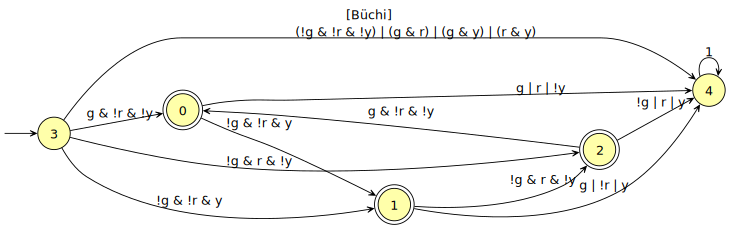

  I: I Total Edges Out: 1
	3: 1
  0: 0 Total Edges Out: 2
	1: ((!g & !r) & y)
	4: ((g | r) | !y)
  1: 1 Total Edges Out: 2
	2: ((!g & r) & !y)
	4: ((g | !r) | y)
  2: 2 Total Edges Out: 2
	0: ((g & !r) & !y)
	4: ((!g | r) | y)
  3: 3 Total Edges Out: 4
	0: ((g & !r) & !y)
	1: ((!g & !r) & y)
	2: ((!g & r) & !y)
	4: (((((!g & !r) & !y) | (g & r)) | (g & y)) | (r & y))
  4: 4 Total Edges Out: 1
	4: 1

Predicates:  ['g', 'r', 'y']
Terminals:   ['4']
Start State: 3


In [856]:
formula.printSelf()
formula.showGraph(graphPrint,graphSource,graphFile)

#auto.printGraph()

print(auto)
print(f'Predicates:  {auto.predicates}')
print(f'Terminals:   {auto.terminals}')
print(f'Start State: {formula.getStartState()}')


In [730]:
allTraces = ''
auto.reset()

print(f'{dLineSeparator}\nRun of Length {runLen}\n')
for run in range(0,numRuns):
    auto.genTrace()
    
auto.printVisitLog()

with open('data.txt', 'w') as f:
    f.write(startFormula)
    for trace in (auto.allTraces):
        f.write(trace.traceAsStr())
        print(trace.traceAsStr())
        

Run of Length 20

From State To State Visit Count
I:   0 ->   0  | Edges Out:   0/  1
0:   0 -> 200  | Edges Out:   1/  1
1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;
1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;
1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;
1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;
1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;
1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;
1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;
1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;
1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;
1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;


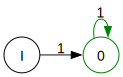

In [731]:
auto.printGraph(traceGraphPrint,traceSource,traceGraphFile)


Run a trace through the automaton

In [279]:
trace = auto.trace
auto.evaluate(trace)
print(f'Evaluation Trace Log: {auto.traceLog}')

Evaluation Trace Log: ['0', '3', '3', '4', '5', '1', '1', '4', '4', '1', '5', '1', '2', '5', '1', '1', '4', '4', '1', '2', '1']


# Compare Automata

This code compares two automata by running traces from automaton A on automaton B and vis versa

In [280]:
compPrint  = True
compSource = False
compFile = {'save'   : False,
             'name'   : path.joinpath('graph'),
             'format' : 'png'}


In [281]:
# formula1 = Formula.setFormula(dOptions,'F(G(p -> X(q))) & G(r -> (F(!s)))')
# formula2 = Formula.setFormula(dOptions,'G(p -> (X(q) & G(r -> F(!s))))')
formula1 = Formula.setFormula(dOptions,'F(G(p -> X(q))) & G(r -> (F(s)))')
formula2 = Formula.setFormula(dOptions,'F(G((p -> X(q))) & G((r -> F(s))))')

auto1 = buildAutomaton(formula1)
auto2 = buildAutomaton(formula2)


Generating LALR tables
Generating LALR tables


Starting formula:
FG(!p | Xq) & G(!r | Fs)


spot.formula("FG(!p | Xq) & G(!r | Fs)")

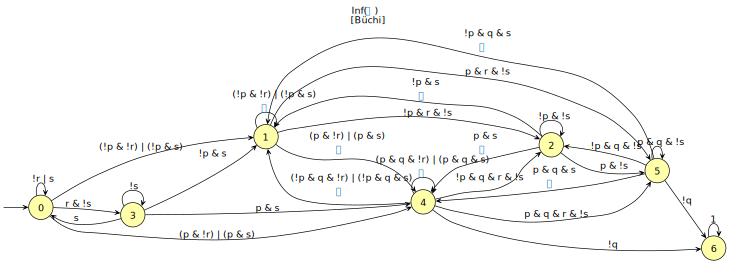

Starting formula:
FG((!p | Xq) & (!r | Fs))


spot.formula("FG((!p | Xq) & (!r | Fs))")

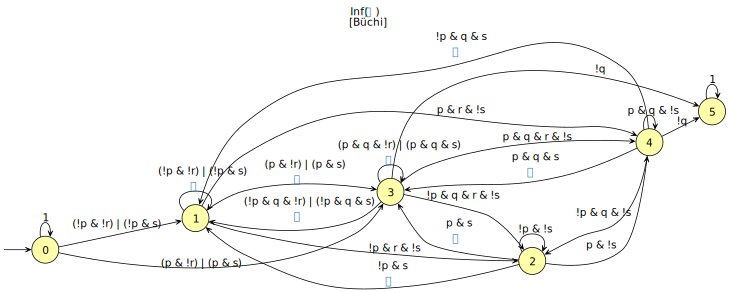

In [282]:
formula1.printSelf()
formula1.showGraph(compPrint,compSource,compFile)
formula2.printSelf()
formula2.showGraph(compPrint,compSource,compFile)


In [283]:
auto1.reset(resetLog=True)
auto2.reset(resetLog=True)
for run in range(0,numRuns):
    auto1.genTrace(tracePrint=False)
    auto2.genTrace(tracePrint=False)
    
print(f'Automaton 1 Traces:')
auto1.printVisitLog()
for trace in (auto1.allTraces):
    print(trace.traceAsStr())
    
print(f'Automaton 2 Traces:')
auto2.printVisitLog()
for trace in (auto2.allTraces):
    print(trace.traceAsStr())

Automaton 1 Traces:
From State To State Visit Count
I:   0 ->   0                                              | Edges Out:   0/  1
0:   0 ->   5   1 ->   3   3 ->   5   4 ->   4             | Edges Out:   4/  4
1:   1 ->   7   2 ->   5   4 ->  11   5 ->   7             | Edges Out:   4/  4
2:   1 ->   3   2 ->   5   4 ->   5   5 ->   8             | Edges Out:   4/  4
3:   0 ->   2   1 ->   2   3 ->   2   4 ->   1             | Edges Out:   4/  4
4:   1 ->   7   2 ->   7   4 ->   1   5 ->   8   6 ->   3  | Edges Out:   5/  5
5:   1 ->   8   2 ->   5   4 ->   4   5 ->   5   6 ->   3  | Edges Out:   5/  5
6:   6 ->  74                                              | Edges Out:   1/  1
r,!s;s;r,!s;!p,s;p,!r;!p,q,s;p,r,!s;!p,q,s;p,r,!s;!p,q,!s;p,!s;p,q,!s;!p,q,!s;!p,!s;p,!s;p,q,s;!p,q,!r;!p,s;p,!r;p,q,r,!s;
!p,!r;!p,s;!p,!r;p,r,!s;p,q,!s;!p,q,!s;p,!s;!p,q,s;p,r,!s;p,q,!s;p,q,s;p,q,r,!s;!p,q,!s;!p,!s;p,!s;!p,q,s;p,!r;!p,q,r,!s;p,!s;p,q,!s;
!r;r,!s;s;!p,s;!p,s;p,!r;!q;1;1;1;1;1;1;1;1;1;1;1;1

In [284]:
for trace in auto2.allTraces:
    auto1.evaluate(trace)
    print(f'Evaluation Trace Log: {auto1.traceLog}')

for trace in auto2.allTraces:
    auto2.evaluate(trace)
    print(f'Evaluation Trace Log: {auto2.traceLog}')

Evaluation Trace Log: ['0', '4', '4', '4', '5', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6']
Evaluation Trace Log: ['0', '1', '4', '5', '2', '2', '4', '2', '1', '1', '4', '1', '4', '1', '5', '2', '2', '5', '2', '5', '2']
No next state @ state: 0 Step: ['1']
Evaluation Trace Log: ['0']
Evaluation Trace Log: ['0', '4', '5', '2', '1', '5', '5', '5', '4', '2', '4', '5', '2', '5', '4', '4', '2', '2', '1', '1', '2']
No next state @ state: 0 Step: ['1']
Evaluation Trace Log: ['0']
Evaluation Trace Log: ['0', '4', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6']
No next state @ state: 0 Step: ['1']
Evaluation Trace Log: ['0']
Evaluation Trace Log: ['0', '1', '1', '5', '2', '5', '4', '5', '5', '2', '1', '4', '1', '4', '1', '4', '2', '5', '4', '4', '1']
Evaluation Trace Log: ['0', '1', '2', '2', '1', '1', '1', '5', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6', '6']
No next state @ state: 0 Step: ['1']


From State To State Visit Count
I:   0 ->   0                                              | Edges Out:   0/  1
0:   0 ->   5   1 ->   3   3 ->   5   4 ->   4             | Edges Out:   4/  4
1:   1 ->   7   2 ->   5   4 ->  11   5 ->   7             | Edges Out:   4/  4
2:   1 ->   3   2 ->   5   4 ->   5   5 ->   8             | Edges Out:   4/  4
3:   0 ->   2   1 ->   2   3 ->   2   4 ->   1             | Edges Out:   4/  4
4:   1 ->   7   2 ->   7   4 ->   1   5 ->   8   6 ->   3  | Edges Out:   5/  5
5:   1 ->   8   2 ->   5   4 ->   4   5 ->   5   6 ->   3  | Edges Out:   5/  5
6:   6 ->  74                                              | Edges Out:   1/  1


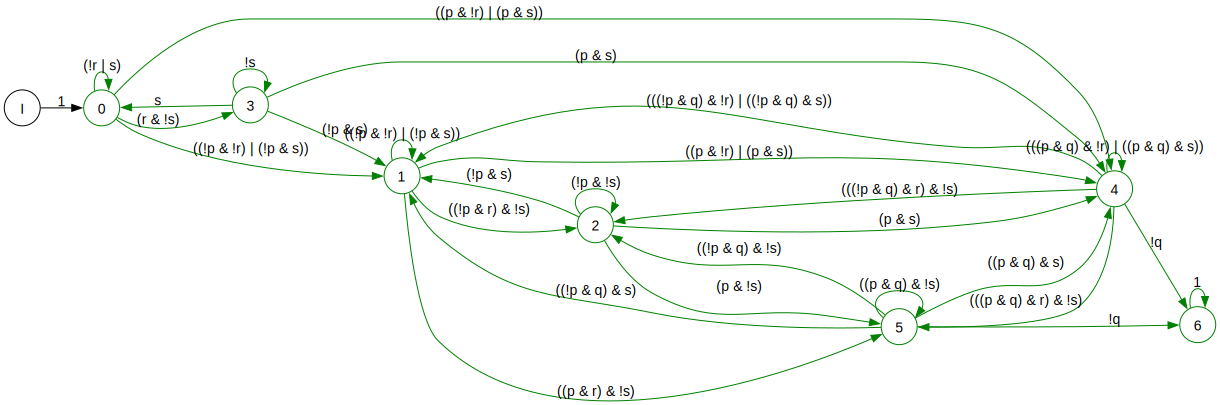

From State To State Visit Count
I:   0 ->   0                                              | Edges Out:   0/  1
0:   0 ->   6   1 ->   7   3 ->   3                        | Edges Out:   3/  3
1:   1 ->   7   2 ->   3   3 ->  11   4 ->   7             | Edges Out:   4/  4
2:   1 ->   8   2 ->   6   3 ->   2   4 ->   8             | Edges Out:   4/  4
3:   1 ->   6   2 ->   7   3 ->   7   4 ->   6   5 ->   4  | Edges Out:   5/  5
4:   1 ->   1   2 ->  11   3 ->   7   4 ->   4   5 ->   2  | Edges Out:   5/  5
5:   5 ->  77                                              | Edges Out:   1/  1


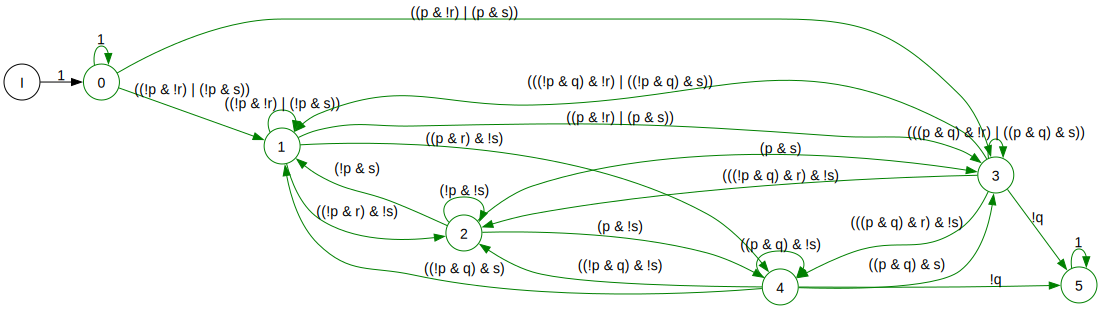

In [285]:
auto1.printVisitLog()
auto1.printGraph(traceGraphPrint,traceSource,traceGraphFile)

auto2.printVisitLog()
auto2.printGraph(traceGraphPrint,traceSource,traceGraphFile)


In [286]:
trace.start()
done = False
while done != True:
    step = trace.next()
    print(step)
    if step == None:
        done = True

0   -> 0  : ['1']
0   -> 0  : ['1']
0   -> 0  : ['1']
0   -> 1  : ['!p', '!r']
1   -> 3  : ['p', 's']
3   -> 5  : ['!q']
5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
None


In [287]:
done = False
while done != True:
    step = trace.back()
    print(step)
    if step == None:
        done = True

5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
5   -> 5  : ['1']
3   -> 5  : ['!q']
1   -> 3  : ['p', 's']
0   -> 1  : ['!p', '!r']
0   -> 0  : ['1']
0   -> 0  : ['1']
0   -> 0  : ['1']
None


In [288]:
a = ['r', 'g', '!y']
b = ['y', 'r']
c = ['r', 'y']
d = [a[i].replace('!','') for i in range(len(a))]
print(f'{d}')
print(set(a).intersection(b))
print(set(b).intersection(a))
print(set(a).intersection(c) == set(a))
print(set(d).intersection(c) == set(d))
print(set(b).intersection(c) == set(b))

['r', 'g', 'y']
{'r'}
{'r'}
False
False
True
